# India's Relative Contribution to GBIF

How does India compare to other countries, both in absolute terms and when normalized by population, land area, and known biodiversity?

In [3]:
import sys; sys.path.insert(0, ".")
from _shared import *
setup_plotting()

india_df = pd.read_parquet(CACHE_DIR / "india_df.parquet")
global_country_counts = pd.read_parquet(CACHE_DIR / "global_country_counts.parquet")["n_records"]
total_global = int(pd.read_json(CACHE_DIR / "metadata.json", typ="series", convert_dates=False)["total_global"])

In [4]:
# Build comparison table
comparison = (
    COUNTRY_REF
    .join(global_country_counts, how="inner")
    .assign(
        records_per_million_pop=lambda x: x.n_records / x.population_m,
        records_per_mkm2=lambda x: x.n_records / x.area_mkm2,
        records_per_species=lambda x: x.n_records / x.est_plant_species,
    )
)

india_row = comparison.loc["IN"]
print("=== India's GBIF Rankings (among 26 reference countries) ===")
for metric, label in [
    ("n_records", "Absolute records"),
    ("records_per_million_pop", "Per million population"),
    ("records_per_mkm2", "Per million km\u00b2"),
    ("records_per_species", "Per known species"),
]:
    rank = (comparison[metric] > india_row[metric]).sum() + 1
    print(f"  {label}: {india_row[metric]:,.0f} (rank {rank}/{len(comparison)})")

=== India's GBIF Rankings (among 26 reference countries) ===
  Absolute records: 200,175 (rank 19/26)
  Per million population: 140 (rank 22/26)
  Per million km²: 60,899 (rank 21/26)
  Per known species: 11 (rank 18/26)


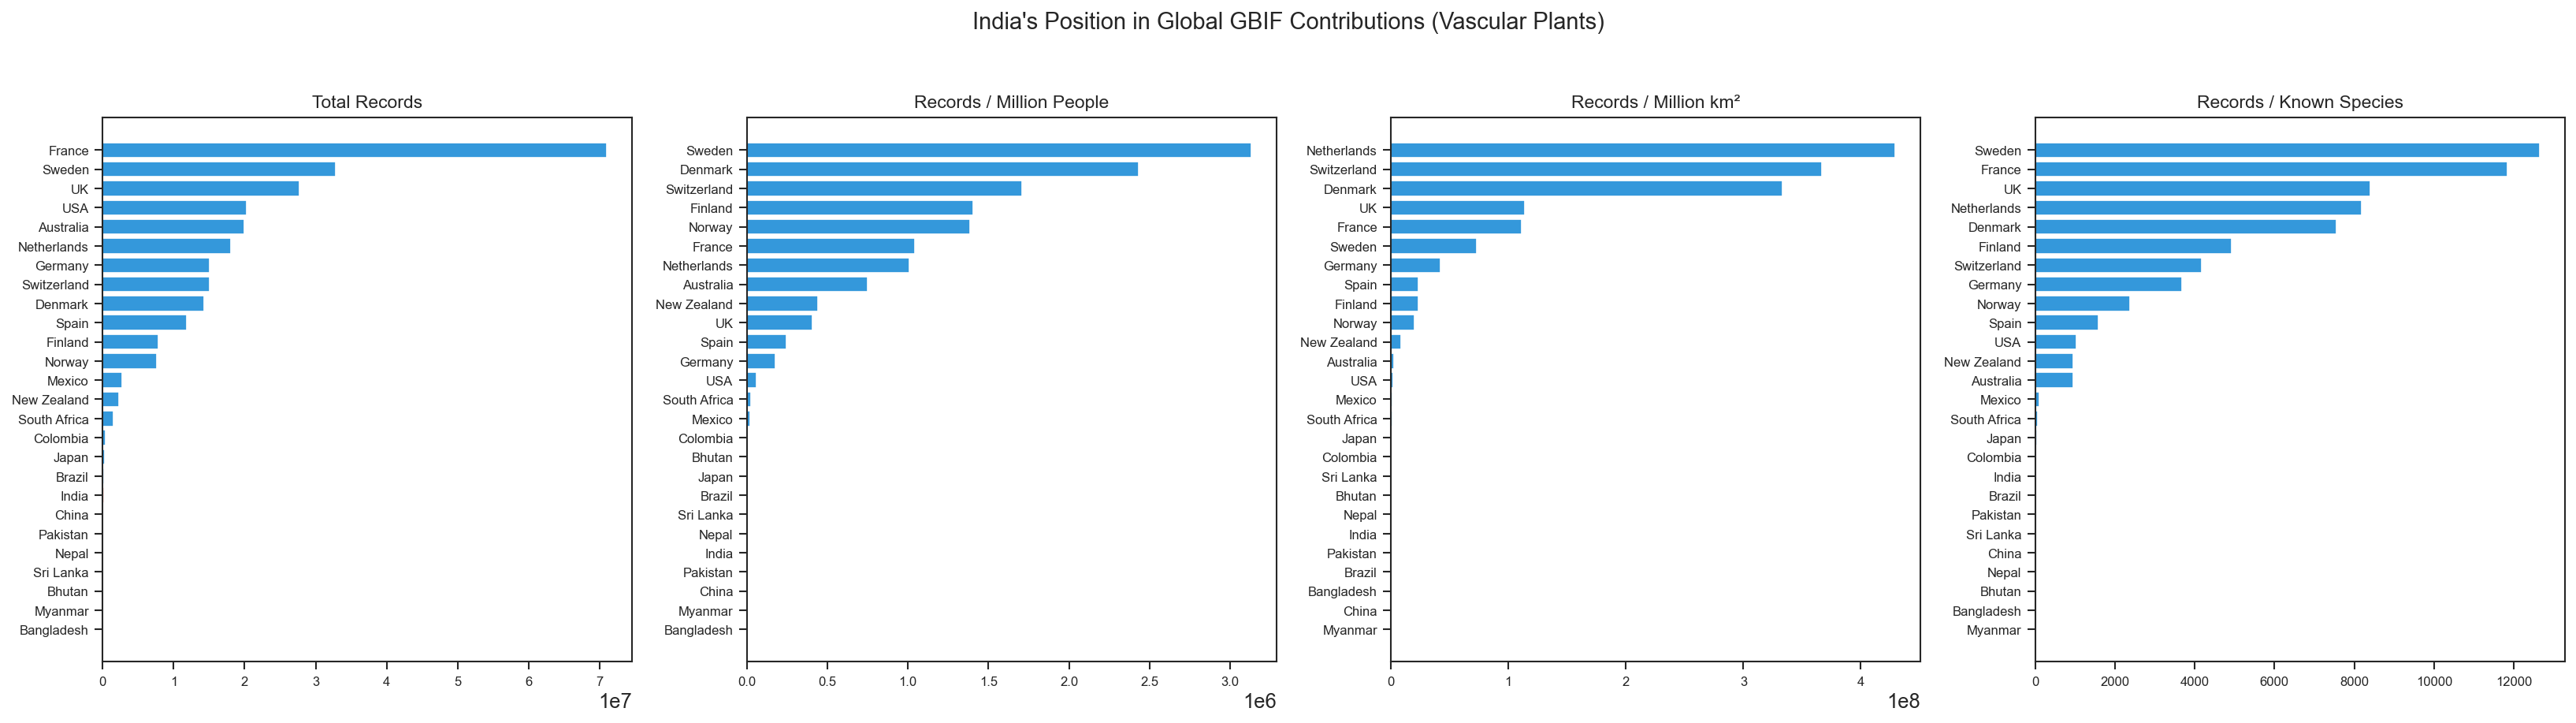

In [5]:
# Figure 1: 4-panel global ranking
fig, axes = plt.subplots(1, 4, figsize=(22, 6))
metrics = [
    ("n_records", "Total Records"),
    ("records_per_million_pop", "Records / Million People"),
    ("records_per_mkm2", "Records / Million km\u00b2"),
    ("records_per_species", "Records / Known Species"),
]

for ax, (col, title) in zip(axes, metrics):
    data = comparison.sort_values(col, ascending=True)
    colors = ["#e74c3c" if idx == "IN" else "#3498db" for idx in data.index]
    ax.barh(data.country_name, data[col], color=colors)
    ax.set_title(title, fontsize=11)
    ax.tick_params(labelsize=8)

fig.suptitle(
    "India's Position in Global GBIF Contributions (Vascular Plants)",
    fontsize=14, y=1.02,
)
plt.tight_layout()
plt.show()

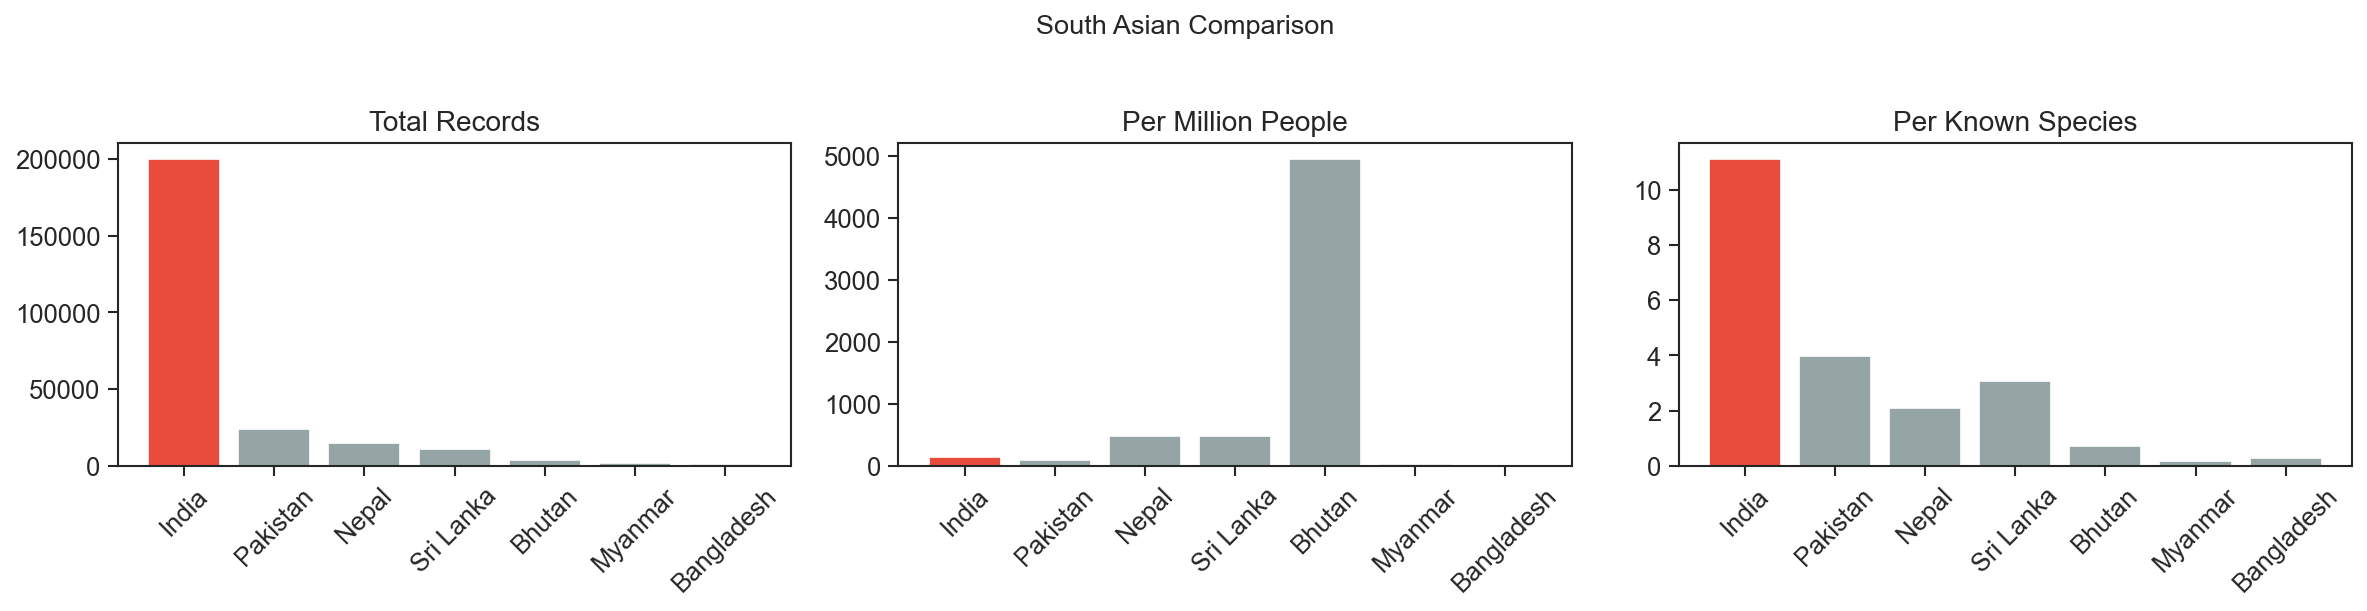

In [6]:
# Figure 2: South Asian comparison
south_asia_codes = ["IN", "PK", "BD", "LK", "NP", "BT", "MM"]
sa_comp = comparison.loc[comparison.index.isin(south_asia_codes)].sort_values(
    "n_records", ascending=False
)

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
for ax, (col, title) in zip(
    axes,
    [
        ("n_records", "Total Records"),
        ("records_per_million_pop", "Per Million People"),
        ("records_per_species", "Per Known Species"),
    ],
):
    colors = [
        "#e74c3c" if c == "IN" else "#95a5a6" for c in sa_comp.index
    ]
    ax.bar(sa_comp.country_name, sa_comp[col], color=colors)
    ax.set_title(title)
    ax.tick_params(axis="x", rotation=45)

fig.suptitle("South Asian Comparison", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

In [7]:
# Journalist-friendly summary
print("KEY FINDINGS \u2014 India's Relative Contribution")
print("=" * 55)
print(f"- India has {india_row.n_records:,.0f} vascular plant records in GBIF")
print(f"- This is {india_row.n_records / total_global:.2%} of the global total ({total_global:,})")
print(f"- Per capita: {india_row.records_per_million_pop:,.0f} records per million people")
fr_pmp = comparison.loc["FR", "records_per_million_pop"]
us_pmp = comparison.loc["US", "records_per_million_pop"]
print(f"  (compare: France ~{fr_pmp:,.0f}, USA ~{us_pmp:,.0f})")
print(f"- India is a megadiverse country with ~18,000 vascular plant species")
print(f"  but only {india_row.records_per_species:,.1f} GBIF records per species")

KEY FINDINGS — India's Relative Contribution
- India has 200,175 vascular plant records in GBIF
- This is 0.06% of the global total (314,644,916)
- Per capita: 140 records per million people
  (compare: France ~1,041,498, USA ~59,623)
- India is a megadiverse country with ~18,000 vascular plant species
  but only 11.1 GBIF records per species
